In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from google.colab import drive
from pathlib import Path
from PIL import Image


Mounted at /content/drive
Found clear images: 128
Found contaminated images: 148


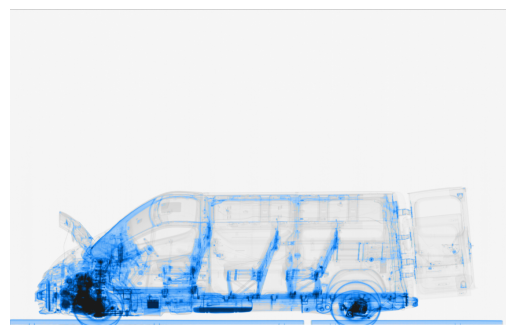

In [2]:

drive.mount('/content/drive')
DATA_ROOT = Path("/content/drive/MyDrive/project/data/NAUKA")
CLEAR_DIR = DATA_ROOT / "czyste"
CONT_DIR  = DATA_ROOT / "brudne"

# recursively find images
clear_imgs = list(CLEAR_DIR.rglob("*.bmp"))
cont_imgs  = list(CONT_DIR.rglob("*.bmp"))

print("Found clear images:", len(clear_imgs))
print("Found contaminated images:", len(cont_imgs))

# display one image properly
img = Image.open(clear_imgs[0])
plt.imshow(img, cmap="gray")
plt.axis("off")
plt.show()


In [3]:
import random
SAMPLE_PER_CLASS = 6
TILE = 512
STRIDE = 384
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

plt.rcParams.update({'figure.max_open_warning': 0})
print("DATA_ROOT", DATA_ROOT)
print("CLEAR_DIR exists:", CLEAR_DIR.exists(), "CONT_DIR exists:", CONT_DIR.exists())

DATA_ROOT /content/drive/MyDrive/project/data/NAUKA
CLEAR_DIR exists: True CONT_DIR exists: True


In [4]:
# Find images recursively & basic counts
img_patterns = ["*.bmp"]
def find_images(base):
    paths = []
    for p in img_patterns:
        paths += list(base.rglob(p))
    return sorted(paths)

clear_imgs = find_images(CLEAR_DIR)
cont_imgs  = find_images(CONT_DIR)
print("Found clear images:", len(clear_imgs))
print("Found contaminated images:", len(cont_imgs))

print("\nSample clear paths:", clear_imgs[:5])
print("\nSample cont paths:", cont_imgs[:5])

Found clear images: 128
Found contaminated images: 148

Sample clear paths: [PosixPath('/content/drive/MyDrive/project/data/NAUKA/czyste/202511180021/48001F003202511180021 czarno.bmp'), PosixPath('/content/drive/MyDrive/project/data/NAUKA/czyste/202511180021/48001F003202511180021.bmp'), PosixPath('/content/drive/MyDrive/project/data/NAUKA/czyste/202511180022/48001F003202511180022 czarno.bmp'), PosixPath('/content/drive/MyDrive/project/data/NAUKA/czyste/202511180022/48001F003202511180022.bmp'), PosixPath('/content/drive/MyDrive/project/data/NAUKA/czyste/202511180023/48001F003202511180023 czarno.bmp')]

Sample cont paths: [PosixPath('/content/drive/MyDrive/project/data/NAUKA/brudne/202511190032/48001F003202511190032 czarno.bmp'), PosixPath('/content/drive/MyDrive/project/data/NAUKA/brudne/202511190032/48001F003202511190032.bmp'), PosixPath('/content/drive/MyDrive/project/data/NAUKA/brudne/202511190033/48001F003202511190033 czarno.bmp'), PosixPath('/content/drive/MyDrive/project/data/NAUK

only 278 img -> not enough to train a yolo/faster-Rcnn detector for scratch but its enough for PatchCore(unsupervised), Tile classifier (weakly supervised), vit/dino feature extraction.
Must use pretrained models for unsupervised/weak supervision -> continue with PatchCore + vit features & optionally small tile classifiers.
Skip supervised detectors due to data shortage

In [5]:
import pandas as pd
# Image sizes & intensity ranges for a small sample
def get_image_info(path):
    img = Image.open(path)
    arr = np.array(img)
    h,w = arr.shape[:2]
    ch = 1 if arr.ndim==2 else arr.shape[2]
    vmin, vmax = float(arr.min()), float(arr.max())
    dtype = arr.dtype
    return {"path": str(path), "w":w, "h":h, "channels":ch, "min":vmin, "max":vmax, "dtype":str(dtype)}

sample_clear = random.sample(clear_imgs, min(len(clear_imgs), 20))
sample_cont  = random.sample(cont_imgs,  min(len(cont_imgs), 20))
info_list = [get_image_info(p) for p in sample_clear + sample_cont]
df_info = pd.DataFrame(info_list)
display(df_info.describe(include='all'))
print(df_info.head())


,path,w,h,channels,min,max,dtype
count,40,40.000000,40.0,40.0,40.000000,40.000000,40
unique,40,NaN,NaN,NaN,NaN,NaN,1
top,/content/drive/MyDrive/project/data/NAUKA/czys...,NaN,NaN,NaN,NaN,NaN,uint8
freq,1,NaN,NaN,NaN,NaN,NaN,40
mean,NaN,2724.200000,1250.0,3.0,9.600000,250.050000,NaN
std,NaN,900.582552,0.0,0.0,8.091781,1.011473,NaN
min,NaN,1967.000000,1250.0,3.0,2.000000,249.000000,NaN
25%,NaN,2182.750000,1250.0,3.0,2.000000,249.000000,NaN
50%,NaN,2317.500000,1250.0,3.0,2.000000,251.000000,NaN
75%,NaN,2561.000000,1250.0,3.0,18.000000,251.000000,NaN


                                                path     w     h  channels  \
0  /content/drive/MyDrive/project/data/NAUKA/czys...  4356  1250         3   
1  /content/drive/MyDrive/project/data/NAUKA/czys...  2561  1250         3   
2  /content/drive/MyDrive/project/data/NAUKA/czys...  2417  1250         3   
3  /content/drive/MyDrive/project/data/NAUKA/czys...  2286  1250         3   
4  /content/drive/MyDrive/project/data/NAUKA/czys...  2389  1250         3   

    min    max  dtype  
0  18.0  249.0  uint8  
1  18.0  249.0  uint8  
2  18.0  249.0  uint8  
3  18.0  249.0  uint8  
4   2.0  251.0  uint8  


Fixed height ~ 1250 px
Width varies 1.3 - 4.3 px
Tiling is necessary since processing 4000x1250 at once is impossible for ViT/DINO
Anomallies (weapons...) are tiny relative to full width => standard cnns/transformers lose spacial detail at large scales
=>tile size = 512x512
=> stride = 384 (25% overlap)
=> tiling required
=> reconstruction via tile scores

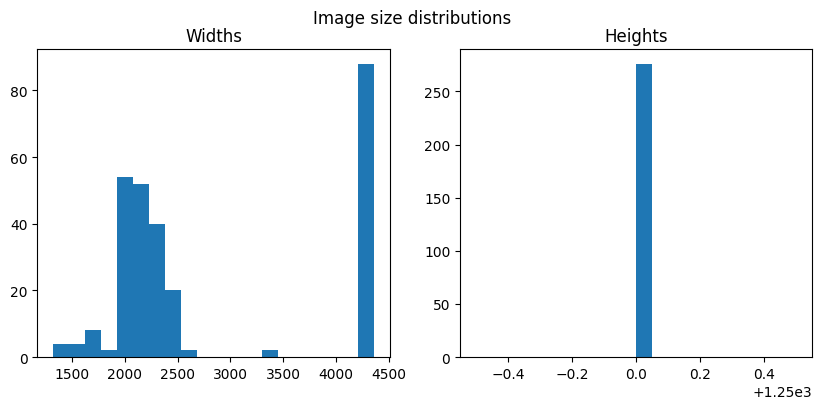

In [7]:
# Size distributions
all_imgs = clear_imgs + cont_imgs
sizes = [get_image_info(p) for p in all_imgs]
sizes_df = pd.DataFrame(sizes)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.hist(sizes_df['w'], bins=20); plt.title("Widths")
plt.subplot(1,2,2); plt.hist(sizes_df['h'], bins=20); plt.title("Heights")
plt.suptitle("Image size distributions")
plt.show()

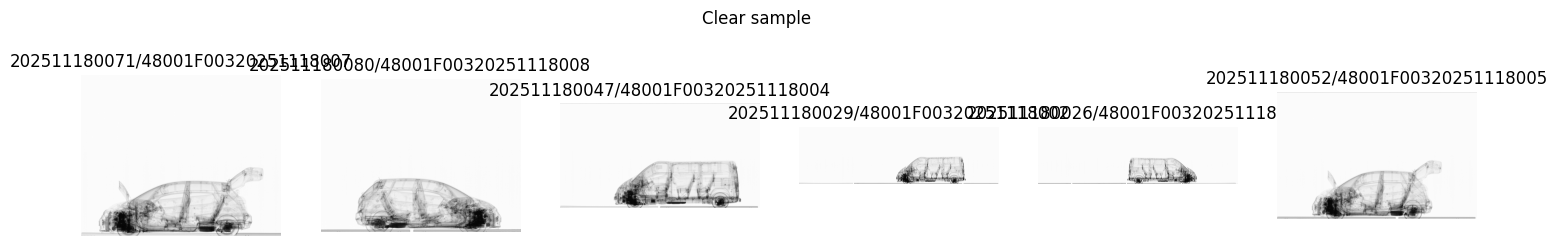

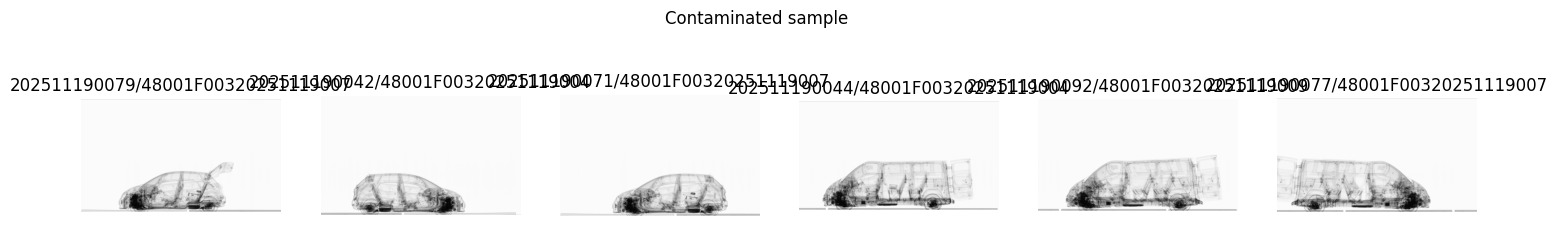

In [8]:
# Visual samples
def show_samples(paths, n=SAMPLE_PER_CLASS, title="Samples"):
    sel = random.sample(paths, min(len(paths), n))
    plt.figure(figsize=(3*n,3))
    for i,p in enumerate(sel):
        img = Image.open(p).convert("L")
        plt.subplot(1,n,i+1); plt.imshow(img, cmap='gray'); plt.title(p.parent.name + "/" + p.name[:20])
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

show_samples(clear_imgs, n=SAMPLE_PER_CLASS, title="Clear sample")
show_samples(cont_imgs, n=SAMPLE_PER_CLASS, title="Contaminated sample")

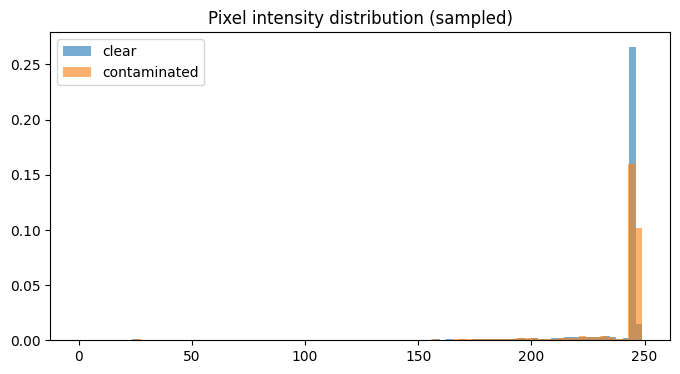

In [9]:
# Intensity histograms (sampled)
def sample_hist(paths, n=50):
    sample = random.sample(paths, min(len(paths), n))
    vals=[]
    for p in sample:
        a = np.array(Image.open(p).convert("L")).flatten()
        vals.append(a)
    vals = np.concatenate(vals)
    return vals

vals_clear = sample_hist(clear_imgs, n=50)
vals_cont  = sample_hist(cont_imgs,  n=50)

plt.figure(figsize=(8,4))
plt.hist(vals_clear, bins=80, alpha=0.6, label='clear', density=True)
plt.hist(vals_cont,  bins=80, alpha=0.6, label='contaminated', density=True)
plt.legend(); plt.title("Pixel intensity distribution (sampled)")
plt.show()


8-bit grayscale X-Ray BMPs, normlaized similarly across classes => Contaminated images do not show a huge global histogram shift => anomalies are likely small and local, not global brightness changes => global brightness cant separate classes, must use local texture + structural features which confirms patchcore is appropriate

Clear mean mean/std: 232.94295636754978 33.66627216594921
Cont mean mean/std: 232.9218682589594 33.720185532590186


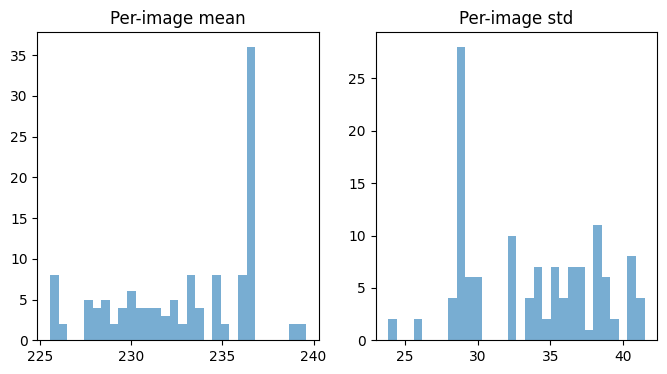

In [10]:
# Per-image mean/std
def per_image_stats(paths):
    rows=[]
    for p in paths:
        a = np.array(Image.open(p).convert("L"))
        rows.append({"path":str(p), "mean":float(a.mean()), "std":float(a.std()), "max":int(a.max()), "min":int(a.min())})
    return pd.DataFrame(rows)

stats_clear = per_image_stats(random.sample(clear_imgs, min(200, len(clear_imgs))))
stats_cont  = per_image_stats(random.sample(cont_imgs, min(200, len(cont_imgs))))

print("Clear mean mean/std:", stats_clear['mean'].mean(), stats_clear['std'].mean())
print("Cont mean mean/std:", stats_cont['mean'].mean(), stats_cont['std'].mean())

plt.figure(figsize=(8,4))
plt.subplot(1,2,1); plt.hist(stats_clear['mean'], bins=30, alpha=0.6, label='clear'); plt.title('Per-image mean')
plt.subplot(1,2,2); plt.hist(stats_clear['std'], bins=30, alpha=0.6, label='clear'); plt.title('Per-image std')
plt.show()


confirms anomalies are extremely subtre & we cannot train a classiiere on whole images - they look identica;
Tile-level classificaiton is possible but will be weak for global differences

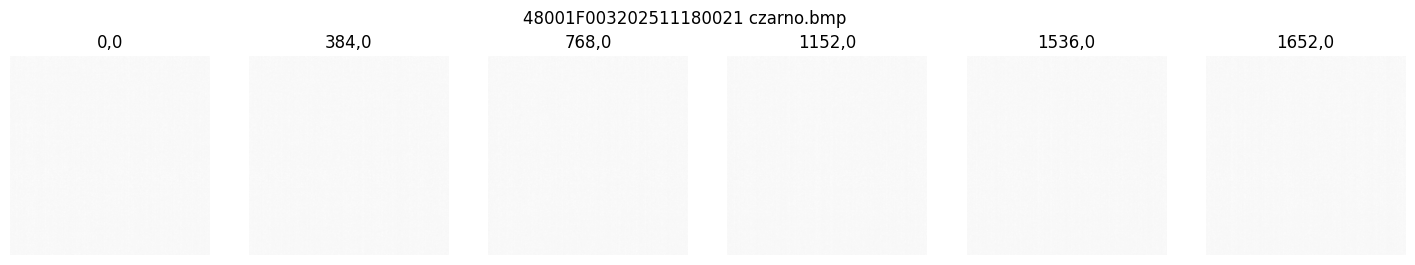

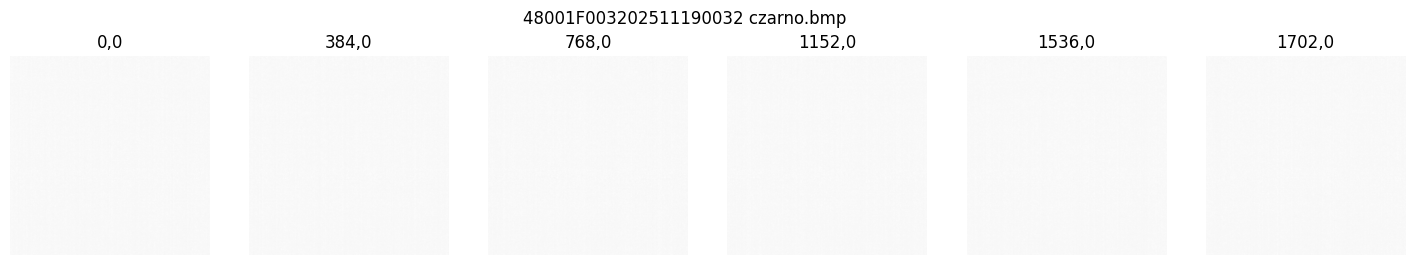

In [11]:
# Tiling a couple of images and showing tiles
def sliding_tiles(img_pil, tile=TILE, stride=STRIDE):
    W,H = img_pil.size
    xs = list(range(0, max(1, W-tile+1), stride))
    ys = list(range(0, max(1, H-tile+1), stride))
    if xs[-1] != W-tile: xs.append(W-tile)
    if ys[-1] != H-tile: ys.append(H-tile)
    coords=[]
    for y in ys:
        for x in xs:
            coords.append((x,y,x+tile,y+tile))
    return coords

def show_tiles_for_image(path, ncols=6):
    img = Image.open(path).convert("RGB")
    coords = sliding_tiles(img)
    sample_coords = coords[:min(len(coords), ncols)]
    plt.figure(figsize=(3*len(sample_coords),3))
    for i,(x1,y1,x2,y2) in enumerate(sample_coords):
        tile = img.crop((x1,y1,x2,y2))
        plt.subplot(1,len(sample_coords),i+1); plt.imshow(tile.convert("L"), cmap='gray'); plt.title(f"{x1},{y1}")
        plt.axis('off')
    plt.suptitle(path.name)
    plt.show()

if len(clear_imgs)>0:
    show_tiles_for_image(clear_imgs[0])
if len(cont_imgs)>0:
    show_tiles_for_image(cont_imgs[0])


X-ray images often have large empty/low-density regions & many tiles will contain only background => handle empty patches & not treat them as anomalies => include them in the memory bank & remove fully empty tiles from training if memory bank is too big

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 246MB/s]


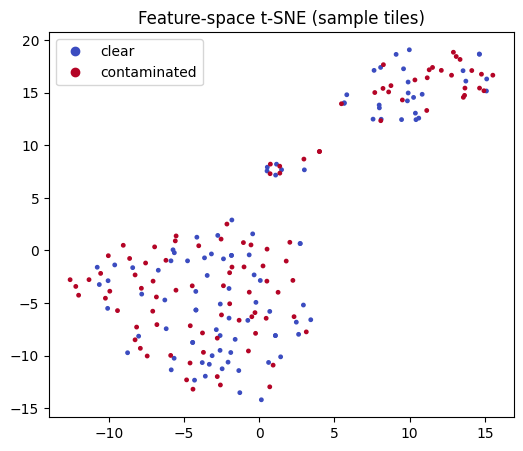

In [12]:
# Feature embedding visualization
DO_TSNE = True
if DO_TSNE:
    import torch, torchvision.transforms as T, torchvision.models as models
    from sklearn.decomposition import PCA
    from sklearn.manifold import TSNE

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    resnet = models.resnet50(pretrained=True).to(device).eval()
    feat_model = torch.nn.Sequential(*list(resnet.children())[:-2]).to(device)
    pool = torch.nn.AdaptiveAvgPool2d((1,1))

    def sample_tiles_from_list(img_paths, n_images=5, tiles_per_img=10):
        tiles=[]
        labels=[]
        for p in img_paths[:n_images]:
            img = Image.open(p).convert("RGB")
            coords = sliding_tiles(img)
            coords = coords[:tiles_per_img]
            for (x1,y1,x2,y2) in coords:
                t = img.crop((x1,y1,x2,y2)).resize((224,224))
                tiles.append(t)
                labels.append(0 if p in clear_imgs else 1)
        return tiles, labels

    sample_count = 200
    sample_clear_imgs = random.sample(clear_imgs, min(10, len(clear_imgs)))
    sample_cont_imgs = random.sample(cont_imgs, min(10, len(cont_imgs)))
    tiles = []
    labels = []
    for p in sample_clear_imgs + sample_cont_imgs:
        img = Image.open(p).convert("RGB")
        coords = sliding_tiles(img)[:10]
        for (x1,y1,x2,y2) in coords:
            t = img.crop((x1,y1,x2,y2)).resize((224,224))
            tiles.append(T.ToTensor()(t))
            labels.append(0 if p in clear_imgs else 1)
    X = torch.stack(tiles).to(device)
    with torch.no_grad():
        out = feat_model(X)  # B,C,Hf,Wf
        out = pool(out).squeeze(-1).squeeze(-1).cpu().numpy()
    # PCA -> TSNE
    pca = PCA(n_components=50, random_state=0).fit_transform(out)
    ts = TSNE(n_components=2, perplexity=30, init='pca', random_state=0)
    X2 = ts.fit_transform(pca)
    plt.figure(figsize=(6,5));
    sc = plt.scatter(X2[:,0], X2[:,1], c=labels, cmap='coolwarm', s=6)
    plt.title("Feature-space t-SNE (sample tiles)"); plt.legend(handles=sc.legend_elements()[0], labels=['clear','contaminated'])
    plt.show()


In [13]:
# Cell 9 — EDA summary
eda_summary = {
    "n_clear_images": len(clear_imgs),
    "n_cont_images": len(cont_imgs),
    "sample_tile": TILE,
    "stride": STRIDE,
    "sample_image_sizes": sizes_df[['w','h']].describe().to_dict(),
}
import json
with open("/content/eda_summary.json","w") as f:
    json.dump(eda_summary, f, indent=2)
print("Saved /content/eda_summary.json")
display(eda_summary)


Saved /content/eda_summary.json


{'n_clear_images': 128,
 'n_cont_images': 148,
 'sample_tile': 512,
 'stride': 384,
 'sample_image_sizes': {'w': {'count': 276.0,
   'mean': 2843.8333333333335,
   'std': 1057.268161276262,
   'min': 1323.0,
   '25%': 2070.0,
   '50%': 2293.0,
   '75%': 4353.0,
   'max': 4358.0},
  'h': {'count': 276.0,
   'mean': 1250.0,
   'std': 0.0,
   'min': 1250.0,
   '25%': 1250.0,
   '50%': 1250.0,
   '75%': 1250.0,
   'max': 1250.0}}}

# **RAAAAAAAAAAAAAAAAAAAAAAAH**

In [78]:
# Imports & Config
from pathlib import Path
import math, time, pickle, random
import numpy as np, pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import torch, torch.nn as nn
import torchvision.transforms as T
import timm
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import normalize
import cv2
import os

# Faiss speedup in the future cuz of no time
try:
    import faiss
    HAS_FAISS = True
except Exception:
    HAS_FAISS = False

TILE_ROOT = Path("./data/car_data_tiles")
CLEAR_DIR = TILE_ROOT / "czyste"
CONT_DIR  = TILE_ROOT / "brudne"
OUT_DIR   = Path("./patchcore_outputs")
OUT_DIR.mkdir(exist_ok=True, parents=True)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH = 32
INPUT_SIZE = 224
PCA_DIM = 256
MEMORY_BANK_SIZE = 50000   # random subsample of clear features
K = 5
TOP_K_AGG = 5
USE_COSINE = True
RNG = np.random.default_rng(seed=0)

print("Device:", DEVICE, "FAISS:", HAS_FAISS)
print("Clear tiles:", len(list(CLEAR_DIR.rglob("*.*"))), "Cont tiles:", len(list(CONT_DIR.rglob('*.*'))))


Device: cuda FAISS: False
Clear tiles: 2838 Cont tiles: 3516


In [79]:
# Cell 1 — load DINO ViT via timm and build transform + feature extractor

VIT_MODEL_NAME = "vit_small_patch16_224_dino"
print("Loading", VIT_MODEL_NAME, "— this may take a few seconds...")

vit = timm.create_model(VIT_MODEL_NAME, pretrained=True).to(DEVICE).eval()

transform = T.Compose([
    T.Resize((INPUT_SIZE, INPUT_SIZE)),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])
augment_transform = T.Compose([
    T.Resize((INPUT_SIZE, INPUT_SIZE)),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(degrees=7),
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

def extract_batch_features(paths, per_patch=False, augment=False):
    feats_list = []
    per_image_outputs = []
    for i in range(0, len(paths), BATCH):
        batch_paths = paths[i:i+BATCH]
        imgs = []
        for p in batch_paths:
            img = Image.open(p).convert("RGB")
            if augment:
                x = augment_transform(img)
            else:
                x = transform(img)
            imgs.append(x)
        x = torch.stack(imgs).to(DEVICE)
        with torch.no_grad():
            out = vit.forward_features(x)  # can be (B, D) or (B, N, D)
        # normalize to CPU
        if isinstance(out, torch.Tensor):
            f = out.cpu()
            if not per_patch:
                # want one vector per image
                if f.ndim == 3:
                    # mean-pool tokens (skip cls if present)
                    if f.size(1) > 1:
                        # detect cls token: check if tokens count is perfect square + 1
                        n_tokens = f.size(1)
                        gw = int(round(math.sqrt(n_tokens)))
                        if gw*gw + 1 == n_tokens:
                            # drop token 0 (cls), mean pool the rest
                            pooled = f[:,1:,:].mean(dim=1)
                        else:
                            pooled = f.mean(dim=1)
                    else:
                        pooled = f.squeeze(1)
                    feats_list.append(pooled.numpy())
                else:
                    feats_list.append(f.numpy())
            else:
                # per_patch -> we want per-image arrays
                if f.ndim == 3:
                    f_np = f.numpy()  # B x N_tokens x D
                    for arr in f_np:
                        # drop cls if present (if num tokens = perfect square + 1)
                        n_tokens = arr.shape[0]
                        gw = int(round(math.sqrt(n_tokens)))
                        if gw*gw + 1 == n_tokens:
                            arr = arr[1:,:]  # drop cls
                        per_image_outputs.append(arr.astype(np.float32))
                elif f.ndim == 2:
                    # model returned global vector only; treat as single patch
                    for arr in f.numpy():
                        per_image_outputs.append(arr[None,:].astype(np.float32))
        else:
            # if timm returned numpy
            arr = np.array(out)
            if not per_patch:
                feats_list.append(arr)
            else:
                # treat rows as images
                for a in arr:
                    per_image_outputs.append(a.astype(np.float32))
        if (i // BATCH) % 10 == 0:
            print(f"Processed {min(i+len(batch_paths), len(paths))}/{len(paths)}")

    if not per_patch:
        feats = np.vstack(feats_list)
        return feats
    else:
        return per_image_outputs


Loading vit_small_patch16_224_dino — this may take a few seconds...


/usr/local/lib/python3.12/dist-packages/timm/models/_factory.py:138: UserWarning: Mapping deprecated model name vit_small_patch16_224_dino to current vit_small_patch16_224.dino.
  model = create_fn(


In [80]:
clear_paths = sorted([str(p) for p in CLEAR_DIR.rglob("*") if p.suffix.lower() in (".bmp")])
cont_paths  = sorted([str(p) for p in CONT_DIR.rglob("*") if p.suffix.lower() in (".bmp")])

print("Found clear:", len(clear_paths), "contaminated:", len(cont_paths))

Found clear: 2838 contaminated: 3516


In [81]:
import numpy as np
clear_paths = sorted([str(p) for p in CLEAR_DIR.rglob("*") if p.suffix.lower() in (".bmp")])
cont_paths  = sorted([str(p) for p in CONT_DIR.rglob("*") if p.suffix.lower() in (".bmp")])
p = clear_paths[0]
a = np.array(Image.open(p).convert('L'))
print(a.mean(), a.std(), (a < 250).mean())

245.23537063598633 6.191018199463512 1.0


In [82]:
# Feature extracttion & save - potentially implement caching but there is no time for now

AUGMENT_FRACTION = 0.4
SAVE_EVERY = 100
VERBOSE = True
RNG = np.random.default_rng(seed=0)

CACHE_CLEAR_PER_IMAGE = OUT_DIR / "clear_per_image_feats.npy"
CACHE_CLEAR_META = OUT_DIR / "clear_per_image_meta.pkl"

print("Feature extraction")

per_image_feats_orig = extract_batch_features(clear_paths, per_patch=True, augment=False)
per_image_feats_aug  = extract_batch_features(clear_paths, per_patch=True, augment=True)

assert len(per_image_feats_orig) == len(clear_paths), "orig length mismatch"
assert len(per_image_feats_aug)  == len(clear_paths), "aug length mismatch"

clear_per_image = []
clear_meta = []
total_patches = 0

for idx, (pth, arr_o, arr_a) in enumerate(zip(clear_paths, per_image_feats_orig, per_image_feats_aug)):
    if RNG.random() < AUGMENT_FRACTION:
        combined = np.vstack([arr_o, arr_a]).astype(np.float32)
        used_aug = True
    else:
        combined = arr_o.astype(np.float32)
        used_aug = False

    # fallback for empty arrays
    if combined.size == 0:
        D = arr_o.shape[1]
        combined = np.zeros((1, D), dtype=np.float32)

    # infer grid from original token count for visualization
    n_tokens = arr_o.shape[0]
    gw = int(round(math.sqrt(n_tokens)))
    if gw * gw != n_tokens:
        gw = int(math.floor(math.sqrt(max(1, n_tokens))))
        if VERBOSE:
            print(f"Warning: token count {n_tokens} not square for {pth}; using gw={gw}")

    clear_per_image.append(combined)
    clear_meta.append({
        "path": pth,
        "num_patches": combined.shape[0],
        "grid_h": gw,
        "grid_w": gw,
        "used_aug": bool(used_aug)
    })
    total_patches += combined.shape[0]

    # periodic partial save checkpoint
    if SAVE_EVERY and (idx + 1) % SAVE_EVERY == 0:
        np.save(CACHE_CLEAR_PER_IMAGE, np.array(clear_per_image, dtype=object), allow_pickle=True)
        with open(CACHE_CLEAR_META, "wb") as f:
            pickle.dump(clear_meta, f)
        if VERBOSE:
            print(f"Progress saved at {idx+1}/{len(clear_paths)} images (total_patches={total_patches})")


np.save(CACHE_CLEAR_PER_IMAGE, np.array(clear_per_image, dtype=object), allow_pickle=True)
with open(CACHE_CLEAR_META, "wb") as f:
    pickle.dump(clear_meta, f)

print("Done extraction. Images:", len(clear_per_image), "| Total patches:", total_patches)
print("Saved:", CACHE_CLEAR_PER_IMAGE, CACHE_CLEAR_META)


Feature extraction
Processed 32/2838
Processed 352/2838
Processed 672/2838
Processed 992/2838
Processed 1312/2838
Processed 1632/2838
Processed 1952/2838
Processed 2272/2838
Processed 2592/2838
Processed 32/2838
Processed 352/2838
Processed 672/2838
Processed 992/2838
Processed 1312/2838
Processed 1632/2838
Processed 1952/2838
Processed 2272/2838
Processed 2592/2838
Progress saved at 100/2838 images (total_patches=26264)
Progress saved at 200/2838 images (total_patches=52920)
Progress saved at 300/2838 images (total_patches=78792)
Progress saved at 400/2838 images (total_patches=106428)
Progress saved at 500/2838 images (total_patches=132888)
Progress saved at 600/2838 images (total_patches=160132)
Progress saved at 700/2838 images (total_patches=188160)
Progress saved at 800/2838 images (total_patches=215992)
Progress saved at 900/2838 images (total_patches=242060)
Progress saved at 1000/2838 images (total_patches=269108)
Progress saved at 1100/2838 images (total_patches=297528)
Progr

In [85]:
# SANITY CHECK - to avoid previously encountered errors
print("clear_paths:", len(clear_paths))
print("clear_per_image:", len(clear_per_image))
for i in range(min(5, len(clear_per_image))):
    arr = clear_per_image[i]
    meta = clear_meta[i]
    print(i, "patches:", arr.shape, "grid:", meta['grid_h'], "used_aug:", meta.get('used_aug'))
total_patches = sum(a.shape[0] for a in clear_per_image)
D = clear_per_image[0].shape[1]
est_gb = total_patches * D * 4 / (1024**3)
print(f"TOTAL PATCHES {total_patches}, D {D}, approx stacked RAM {est_gb:.2f} GB")


clear_paths: 2838
clear_per_image: 2838
0 patches: (196, 384) grid: 14 used_aug: False
1 patches: (392, 384) grid: 14 used_aug: True
2 patches: (392, 384) grid: 14 used_aug: True
3 patches: (392, 384) grid: 14 used_aug: True
4 patches: (196, 384) grid: 14 used_aug: False
TOTAL PATCHES 782824, D 384, approx stacked RAM 1.12 GB


In [86]:
# Build PCA on subset & construct memory bank with per-image balanced sampling
all_clear_feats = np.vstack(clear_per_image).astype(np.float32)
print("Total clear patches:", all_clear_feats.shape)

# PCA fit on subset
max_pca_fit = min(50000, all_clear_feats.shape[0])
sample_idx = RNG.choice(all_clear_feats.shape[0], max_pca_fit, replace=False)
pca = PCA(n_components=min(PCA_DIM, all_clear_feats.shape[1], max_pca_fit), whiten=True, random_state=0)
print("Fitting PCA on", len(sample_idx), "patch samples")
pca.fit(all_clear_feats[sample_idx])
clear_feats_pca = pca.transform(all_clear_feats)
np.save(OUT_DIR/"clear_feats_pca.npy", clear_feats_pca)
with open(OUT_DIR/"pca.pkl","wb") as f: pickle.dump(pca, f)
print("PCA done, new shape:", clear_feats_pca.shape)

# Memory bank construction: limit number of patches per image to ensure diversity
per_image_limit = int(np.ceil(MEMORY_BANK_SIZE / max(1, len(clear_per_image))))
bank_list = []
for arr in clear_per_image:
    # arr: (num_patches, D)
    arr_pca = pca.transform(arr)
    if arr_pca.shape[0] > per_image_limit:
        sel = RNG.choice(arr_pca.shape[0], per_image_limit, replace=False)
        bank_list.append(arr_pca[sel])
    else:
        bank_list.append(arr_pca)
memory_bank = np.vstack(bank_list).astype(np.float32)
bank_size = memory_bank.shape[0]
if K > bank_size:
    print(f"Warning: K ({K}) > memory bank size ({bank_size}). Clamping K to {min(1, bank_size)}")
    K = max(1, bank_size)

# final subsample if still too large
if memory_bank.shape[0] > MEMORY_BANK_SIZE:
    sel = RNG.choice(memory_bank.shape[0], MEMORY_BANK_SIZE, replace=False)
    memory_bank = memory_bank[sel]
print("Memory bank before normalize:", memory_bank.shape)

if USE_COSINE:
    memory_bank = normalize(memory_bank, axis=1).astype(np.float32)

np.save(OUT_DIR/"memory_bank.npy", memory_bank)
print("Final memory bank shape & sample:", memory_bank.shape)


Total clear patches: (782824, 384)
Fitting PCA on 50000 patch samples
PCA done, new shape: (782824, 256)
Memory bank before normalize: (50000, 256)
Final memory bank shape & sample: (50000, 256)


In [87]:
# Build index
if HAS_FAISS:
    d = memory_bank.shape[1]
    index = faiss.IndexFlatL2(d)  # we will store normalized vectors if using cosine -> we can use inner product by converting
    index.add(memory_bank)
    print("FAISS IndexFlatL2 created - we store normalized vectors.")
else:
    # nearest neighbours
    metric = 'cosine' if USE_COSINE else 'euclidean'
    nn = NearestNeighbors(n_neighbors=K, algorithm='auto', metric=metric).fit(memory_bank)
    print("NearestNeighbors ready, metric:", metric)


NearestNeighbors ready, metric: cosine


In [88]:
# Extract contaminated per-patch features, compute per-patch distances & per-image scores
from pathlib import Path
CACHE_CONT_PER_IMAGE = OUT_DIR / "cont_per_image_feats.npy"
CACHE_CONT_META = OUT_DIR / "cont_per_image_meta.pkl"

print("Extracting per-patch features for contaminated tiles...")
cont_per_image = extract_batch_features(cont_paths, per_patch=True, augment=False)
cont_meta = []
for p, arr in zip(cont_paths, cont_per_image):
    num_patches = arr.shape[0]
    gw = int(round(math.sqrt(num_patches)))
    cont_meta.append({"path": p, "num_patches": num_patches, "grid_h": gw, "grid_w": gw})

print("Computing patch-wise distances & per-image anomaly scores ")
all_scores = []
all_patch_maps = []
all_patch_max = []

if 'index' not in globals() and 'nn' not in globals():
    raise RuntimeError("No index or nn found")

for arr in cont_per_image:
    arr_pca = pca.transform(arr.astype(np.float32))  # (num_patches, PCA_DIM)
    if USE_COSINE:
        arr_pca = normalize(arr_pca, axis=1).astype(np.float32)

    if HAS_FAISS:
        q = np.ascontiguousarray(arr_pca.astype(np.float32))
        Dmat, I = index.search(q, min(K, index.ntotal if hasattr(index, "ntotal") else K))
        patch_scores = Dmat.mean(axis=1)
    else:
        Dmat, I = nn.kneighbors(arr_pca, n_neighbors=min(K, memory_bank.shape[0]), return_distance=True)
        patch_scores = Dmat.mean(axis=1) if USE_COSINE else (Dmat**2).mean(axis=1)

    # Aggregation
    if len(patch_scores) > TOP_K_AGG:
        topk = np.sort(patch_scores)[-TOP_K_AGG:]
        img_score = float(topk.mean())
    else:
        img_score = float(patch_scores.max())

    all_scores.append(img_score)
    all_patch_max.append(float(patch_scores.max()))
    all_patch_maps.append(patch_scores.astype(np.float32))


df = pd.DataFrame({"tile": [m["path"] for m in cont_meta], "score": all_scores})
df = df.sort_values("score", ascending=False).reset_index(drop=True)
df.to_csv(OUT_DIR/"anomaly_scores.csv", index=False)
np.save(OUT_DIR/"all_patch_maps.npy", np.array(all_patch_maps, dtype=object), allow_pickle=True)
with open(OUT_DIR/"cont_patch_meta.pkl","wb") as f: pickle.dump(cont_meta, f)

print("Recomputed & saved anomaly_scores.csv and all_patch_maps.npy")
print(df.head())


Extracting per-patch features for contaminated tiles...
Processed 32/3516
Processed 352/3516
Processed 672/3516
Processed 992/3516
Processed 1312/3516
Processed 1632/3516
Processed 1952/3516
Processed 2272/3516
Processed 2592/3516
Processed 2912/3516
Processed 3232/3516
Computing patch-wise distances & per-image anomaly scores 
Recomputed & saved anomaly_scores.csv and all_patch_maps.npy
                                                tile     score
0  /content/drive/MyDrive/project/data/car_data_t...  0.737815
1  /content/drive/MyDrive/project/data/car_data_t...  0.736841
2  /content/drive/MyDrive/project/data/car_data_t...  0.732278
3  /content/drive/MyDrive/project/data/car_data_t...  0.732019
4  /content/drive/MyDrive/project/data/car_data_t...  0.731681


In [89]:
# Generate heatmap for a given contaminated image index (reconstruction & smoothing)
def make_heatmap_for_index(i, alpha=0.7, colormap=cv2.COLORMAP_JET, blur_ksize=(5,5)):
    meta = cont_meta[i]
    p = meta['path']
    patch_scores = all_patch_maps[i]  # 1D array length = grid_h*grid_w
    gh, gw = meta['grid_h'], meta['grid_w']
    # reshape to grid
    score_map = patch_scores.reshape(gh, gw)
    # normalize to 0..1
    score_map = (score_map - score_map.min()) / (score_map.max() - score_map.min() + 1e-9)
    # upsample to tile size
    orig = np.array(Image.open(p).convert("RGB"))
    h, w = orig.shape[0], orig.shape[1]
    heat_up = cv2.resize(score_map, (w, h), interpolation=cv2.INTER_LINEAR)
    # smoothing
    heat_up = cv2.GaussianBlur(heat_up, blur_ksize, 0)
    # convert to color
    heat_color = cv2.applyColorMap((255 * heat_up).astype(np.uint8), colormap)
    heat_color = cv2.cvtColor(heat_color, cv2.COLOR_BGR2RGB)
    overlay = (heat_color.astype(np.float32) * alpha + orig.astype(np.float32) * (1-alpha)).astype(np.uint8)
    return Image.fromarray(overlay), heat_up

topk = df.head(10)
out_visual_dir = OUT_DIR/"visuals"; out_visual_dir.mkdir(exist_ok=True)
for idx, row in topk.iterrows():
    tile = row['tile']
    i = next(j for j,m in enumerate(cont_meta) if m['path'] == tile)
    overlay_img, heat = make_heatmap_for_index(i)
    overlay_img.save(out_visual_dir/f"top_{idx}_overlay.png")
print("Saved top overlays to", out_visual_dir)


Saved top overlays to /content/drive/MyDrive/project/data/patchcore_quick/visuals


Saved top overlays to /content/drive/MyDrive/project/data/patchcore_quick/visuals


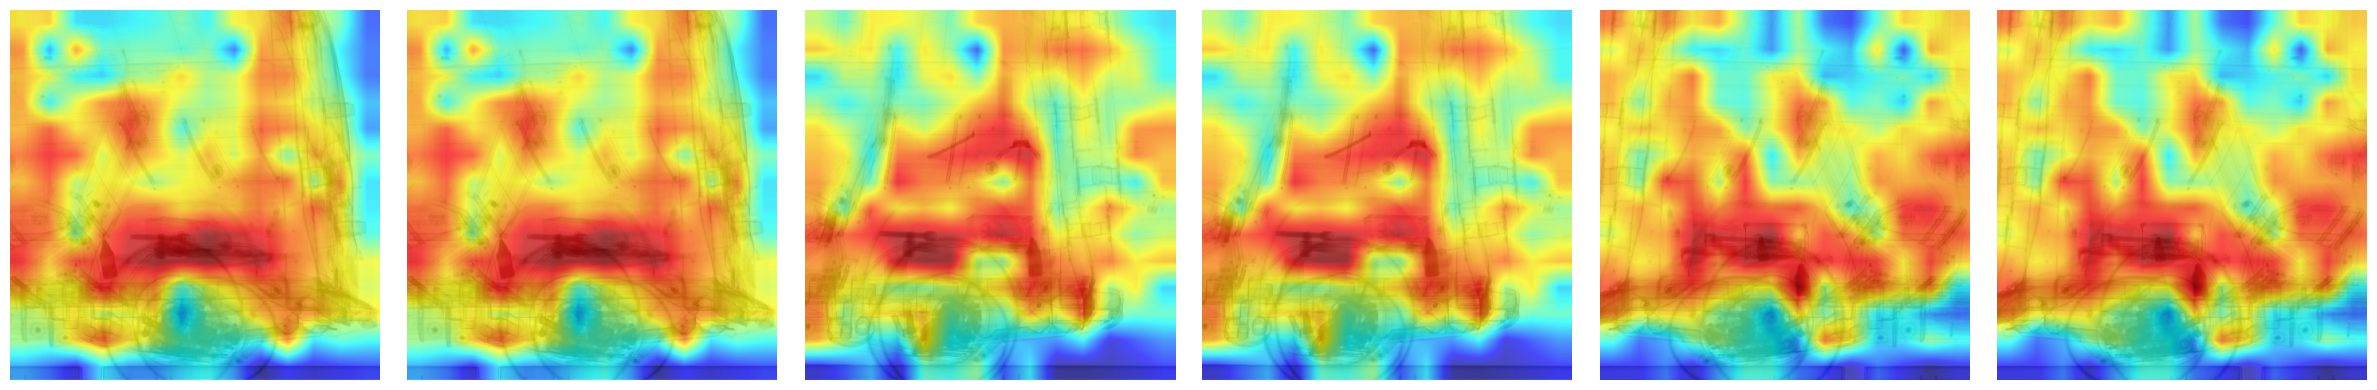

In [90]:
# Save + display top-K overlays inline
from IPython.display import display
import matplotlib.pyplot as plt
from PIL import Image

TOP_K = 6   # how many to show inline
out_visual_dir = OUT_DIR / "visuals"
out_visual_dir.mkdir(exist_ok=True)

topk = df.head(10)

saved_paths = []
for idx, row in topk.iterrows():
    tile = row['tile']
    i = next(j for j, m in enumerate(cont_meta) if m['path'] == tile)
    overlay_img, heat = make_heatmap_for_index(i)
    out_path = out_visual_dir / f"top_{idx}_overlay.png"
    overlay_img.save(str(out_path))
    saved_paths.append(str(out_path))

print("Saved top overlays to", out_visual_dir)

# Display first TOP_K inline in a single row (resize to fit)
n_show = min(TOP_K, len(saved_paths))
fig, axes = plt.subplots(1, n_show, figsize=(4*n_show, 4))
if n_show == 1:
    axes = [axes]
for ax, p in zip(axes, saved_paths[:n_show]):
    im = Image.open(p).convert("RGB")
    ax.imshow(im)
    ax.axis('off')
plt.tight_layout()
plt.show()


In [91]:
#TILE CLASSIFIER: global ViT features
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

OUT_DIR_TILES = Path("./data/tiles_cnn")
OUT_DIR_TILES.mkdir(exist_ok=True, parents=True)

print("Extracting global vit features for tile classifier...")
all_tiles = clear_paths + cont_paths
feats_all = extract_batch_features(all_tiles, per_patch=False)
X = feats_all
print("Extracted global features:", X.shape)
y = np.array([0]*len(clear_paths) + [1]*len(cont_paths))

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

clf = LogisticRegression(max_iter=2000)
clf.fit(X_train, y_train)

# Evaluate on validation set
y_pred = clf.predict(X_val)
print("Classification Report:")
print(classification_report(y_val, y_pred))
print("Confusion Matrix:")
print(confusion_matrix(y_val, y_pred))

# Save classifier and datasets
with open(OUT_DIR_TILES/"tile_classifier.pkl", "wb") as f:
    pickle.dump(clf, f)
np.save(OUT_DIR_TILES/"tile_classifier_features.npy", X)
np.save(OUT_DIR_TILES/"tile_classifier_labels.npy", y)

# Save predicted probabilities & sorted
all_probs = clf.predict_proba(X)[:, 1]
df_clf = pd.DataFrame({"tile": all_tiles, "label": y, "prob_contaminated": all_probs})
df_clf = df_clf.sort_values("prob_contaminated", ascending=False)
df_clf.to_csv(OUT_DIR_TILES/"tile_classifier_scores.csv", index=False)
print("Saved tile_classifier_scores.csv")


Extracting global vit features for tile classifier (NO CACHING)...
Processed 32/6354
Processed 352/6354
Processed 672/6354
Processed 992/6354
Processed 1312/6354
Processed 1632/6354
Processed 1952/6354
Processed 2272/6354
Processed 2592/6354
Processed 2912/6354
Processed 3232/6354
Processed 3552/6354
Processed 3872/6354
Processed 4192/6354
Processed 4512/6354
Processed 4832/6354
Processed 5152/6354
Processed 5472/6354
Processed 5792/6354
Processed 6112/6354
Extracted global features: (6354, 384)
Classification Report:
              precision    recall  f1-score   support

           0       0.69      0.63      0.66       710
           1       0.72      0.78      0.75       879

    accuracy                           0.71      1589
   macro avg       0.71      0.70      0.70      1589
weighted avg       0.71      0.71      0.71      1589

Confusion Matrix:
[[447 263]
 [197 682]]
Saved tile_classifier_scores.csv


In [92]:
# FINAL MERGE: PatchCore anomaly + Tile classifier, normalization & final ranking
OUT_FINAL = OUT_DIR
df_an = pd.read_csv(OUT_DIR/"anomaly_scores.csv")
df_clf = pd.read_csv(OUT_DIR_TILES/"tile_classifier_scores.csv")

df = df_an.merge(df_clf[['tile','prob_contaminated']], on='tile', how='left')

# normalization
df['anomaly_norm'] = (df['score'] - df['score'].min()) / (df['score'].max() - df['score'].min() + 1e-9)
df['clf_norm']     = (df['prob_contaminated'] - df['prob_contaminated'].min()) / (df['prob_contaminated'].max() - df['prob_contaminated'].min() + 1e-9)

ALPHA = 0.65
df['final_score'] = ALPHA * df['anomaly_norm'] + (1-ALPHA) * df['clf_norm']

df = df.sort_values('final_score', ascending=False).reset_index(drop=True)
df.to_csv(OUT_DIR/"final_ranking.csv", index=False)
print("Saved final_ranking.csv — top 10:")
print(df.head(10))


Saved final_ranking.csv — top 10:
                                                tile     score  \
0  /content/drive/MyDrive/project/data/car_data_t...  0.732278   
1  /content/drive/MyDrive/project/data/car_data_t...  0.732019   
2  /content/drive/MyDrive/project/data/car_data_t...  0.731681   
3  /content/drive/MyDrive/project/data/car_data_t...  0.729467   
4  /content/drive/MyDrive/project/data/car_data_t...  0.726747   
5  /content/drive/MyDrive/project/data/car_data_t...  0.726579   
6  /content/drive/MyDrive/project/data/car_data_t...  0.724227   
7  /content/drive/MyDrive/project/data/car_data_t...  0.723636   
8  /content/drive/MyDrive/project/data/car_data_t...  0.728074   
9  /content/drive/MyDrive/project/data/car_data_t...  0.726638   

   prob_contaminated  anomaly_norm  clf_norm  final_score  
0           0.998665      0.983753  0.998809     0.989022  
1           0.998676      0.982994  0.998820     0.988533  
2           0.985859      0.982001  0.985809     0.983334  